In [20]:
# This section of the code is for all of my imports
import os
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
import astropy.io.fits as fits
import pandas as pd
from datetime import datetime
import glob
import matplotlib.cm as cm

# This allows me to access my flash drive that im working off of
os.chdir('/Volumes/Flash Drive')

In [2]:
# This section loads all CSV files from the directory

Path = '/Volumes/Flash Drive/Saturns rings Research/Data From Center of Ringlets CSV files/Ringlet Edges'

# Get all CSV files in the directory
csv_files = glob.glob(os.path.join(Path, '*.csv'))

print(f"Found {len(csv_files)} CSV files:")
for csv_file in csv_files:
    print(f"  - {os.path.basename(csv_file)}")

Found 12 CSV files:
  - BetCen_075I_1km_ringlet_threshold_data.csv
  - BetCen_077E_1km_ringlet_threshold_data.csv
  - BetCen_077I_1km_ringlet_threshold_data.csv
  - BetCen_078E_1km_ringlet_threshold_data.csv
  - BetCen_081I_1km_ringlet_threshold_data.csv
  - BetCen_085I_1km_ringlet_threshold_data.csv
  - BetCen_089I_1km_ringlet_threshold_data.csv
  - BetCen_092E_1km_ringlet_threshold_data.csv
  - BetCen_096I_1km_ringlet_threshold_data.csv
  - BetCen_102I_1km_ringlet_threshold_data.csv
  - BetCen_104E_1km_ringlet_threshold_data.csv
  - BetCen_104I_1km_ringlet_threshold_data.csv


In [3]:
# This Section is the formulas to convert from UTC to ET time, im working off of ET time

# This formula gets the UTC and ET offset due to leap seconds, number is in seconds
def utc_to_et_offset(year):
    """
    Get the offset between UTC and ET (TDB) in seconds for 2008.
    
    For 2008:
    - Leap seconds accumulated by 2008: 33 seconds
    - TT-TAI offset: 32.184 seconds
    - ET ≈ TDB ≈ TT for most purposes
    - So ET - UTC ≈ 33 + 32.184 = 65.184 seconds
    """
    
    ls = 33  # Leap Seconds since 2008

    # TT - TAI offset is always 32.184 seconds
    tt_tai_offset = 32.184
    
    # ET ≈ TDB ≈ TT = UTC + leap_seconds + 32.184
    et_utc_offset = ls + tt_tai_offset
    
    return et_utc_offset # Seconds

# This section of the code converts the UTC Julian Date to ET Julian Date adding in the leap seconds offset
def convert_paper_time_to_et(jd_utc):
    """
    Convert the paper's UTC-based Julian Date to ET-based Julian Date.
    
    Parameters:
    -----------
    jd_utc : float
        Julian Date in UTC (as used in the paper)
    
    Returns:
    --------
    jd_et : float
        Julian Date in Ephemeris Time
    """
    
    # Get offset for 2008
    et_utc_offset_2008 = utc_to_et_offset(2008)
    
    # Convert to ET
    initial_time = jd_utc + (et_utc_offset_2008 / 86400.0)
    
    return initial_time # Seconds


In [4]:
# This section defines the True Anamoly formula and the radius formula

def calculate_radius_true_anomaly(a, e, true_anomaly):
    """
    Calculate the radius at a given true anomaly for a Keplerian ellipse.
    
    This implements equation (2) from the paper:
    r(λ,t) = a(1 - e²) / (1 + e·cos(f))
    f = λ - ϖ = λ - ϖ₀ - ϖ̇(t - t₀)
    
    Parameters:
    -----------
    a : float
        Semi-major axis (km)
    e : float
        Eccentricity (dimensionless, between 0 and 1)
    true_anomaly : float or array
        True anomaly f = λ - ϖ = λ - ϖ₀ - ϖ̇(t - t₀)
        where λ is the inertial longitude and ϖ is the longitude of periapse
    
    Returns:
    --------
    r : float or array
        Radius at the given true anomaly (km)
    """

        # Convert to radians
    #true_anomaly = true_anomaly * np.pi / 180
    
    # Calculate the numerator: a(1 - e²)
    numerator = a * (1 - e**2)
    
    # Calculate the denominator: 1 + e·cos(f)
    denominator = 1 + e * np.cos(true_anomaly)
    
    # Calculate radius
    r = numerator / denominator
    
    return r

def calculate_true_anomaly(longitude #Inertial longitude (LON value)
                           ,varpi_0 # Longitude periapse (Fixed)
                           ,varpi_dot #Rrecession rate (Fixed)
                           ,time # Time from data
                           ,initial_time): # Time from paper (fixed)
    """
    Calculate the true anomaly from orbital parameters.
    
    From the paper: f = λ - ϖ = λ - ϖ₀ - ϖ̇(t - t₀)
    
    Parameters:
    -----------
    longitude : float or array
        Inertial longitude λ (degrees)
    varpi_0 (Longitude periapse) : float
        Longitude of periapse at epoch ϖ₀ (degrees)
    varpi_dot (precession rate) : float, optional
        Apsidal precession rate ϖ̇ (degrees/day)
    time : float, optional
        Current time (days)
    initial_time : float, optional
        Epoch time t₀ (days)
    
    Returns:
    --------
    true_anomaly : float or array
        True anomaly f (degrees)
    """
    
    # True anomaly is the angle from periapse
    true_anomaly = longitude - varpi_0 - varpi_dot * (time - initial_time)

    # Wrap to 0-360 degrees
    true_anomaly = true_anomaly % 360
    
    return true_anomaly

def plot_r_vs_true_anomaly(true_anomaly, radii, title=f"\Radius vs True Anomaly Analysis of Titan Ringlet \n File: {csv_files}"):
    """
    Plot radius vs true anomaly.
    
    Parameters:
    -----------
    true_anomaly : array
        True anomaly values in degrees
    radii : array
        Radius values in km
    title : str
        Plot title
    """
    plt.figure(figsize=(10, 6))
    plt.plot(true_anomaly, radii, 'b-', linewidth=2)
    plt.xlabel('True Anomaly, f (degrees)')
    plt.ylabel('Radius (km)')
    plt.title(title)
    plt.grid(True, alpha=0.3)
    plt.show()

In [5]:
# This section defines static parameters and initializes data storage

# J2000 epoch = JD 2451545.0
j2000_jd = 2451545.0

# Paper's epoch
paper_epoch_utc = 2454467.0  # This is in UTC

# Paper's epoch conversion to ET (seconds)
paper_epoch_jd_et = convert_paper_time_to_et(paper_epoch_utc)

# Static orbital parameters/Paper values (these don't change between occultations)
a_paper = 77878.67  # km
e_paper = 2.88*10**-4
aeI = 17.39    # ae Inner
aeO = 27.20    # ae Outer
varpi_0I = 270.54  # degrees Inner
varpi_0O = 270.70  # degrees Outer
varpi_dotI = 22.57503  # ϖ̇ in degrees/day Inner
varpi_dotO = 22.57562  # ϖ̇ in degrees/day Outer

# Initialize lists to store data points from all occultations
# Separate lists for inner and outer edges
all_true_anomaly_inner = []
all_radii_inner = []
all_longitudes_inner = []
all_times_inner = []
all_TAUPLUS_inner = []
all_TAUMINUS_inner = []
all_true_anomaly_outer = []
all_radii_outer = []
all_longitudes_outer = []
all_times_outer = []
all_TAUPLUS_outer = []
all_TAUMINUS_outer = []
all_csv_names = []

In [6]:
# This section loops through all CSV files and processes each one for Titan Ringlet
print(f"\nProcessing {len(csv_files)} CSV files...\n")

for csv_file in csv_files:
    csv_name = os.path.basename(csv_file)
    print(f"Processing: {csv_name}")
    
    try:
        # Load data from CSV
        data = pd.read_csv(csv_file)
        
        # Get Titan inner and outer edge data
        titan_inner = data[data['Ringlet_Position'] == 'Titan_Inner']
        titan_outer = data[data['Ringlet_Position'] == 'Titan_Outer']
        
        if len(titan_inner) == 0 and len(titan_outer) == 0:
            print(f"  ⚠ No Titan ringlet data found in {csv_name}")
            continue
        
        # Process Inner Edge
        if len(titan_inner) > 0:
            # Extract radius value from CSV for inner edge
            a_inner = titan_inner['Radius'].values[0]
            
            # Calculate eccentricity (using ae from paper then using our radial value)
            e_inner = aeI / a_inner
            
            # Get longitude from data
            longitude_inner = titan_inner['LON'].values[0]  # LON in degrees

            # Get TAUPLUS from data
            TAUPLUS_inner = titan_inner['TAUPLUS'].values[0]  # TAUPLUS

            # Get TAUMINUS from data
            TAUMINUS_inner = titan_inner['TAUMINUS'].values[0]  # TAUMINUS
            
            # Convert ET time from seconds to days
            titan_et_days_inner = titan_inner['ET'].values[0] / 86400.0
            
            # Convert to Julian Days
            titan_jd_et_inner = j2000_jd + titan_et_days_inner
            
            # Calculate true anomaly (comes out in degrees after wrapping)
            true_anomaly_inner = calculate_true_anomaly(longitude_inner, varpi_0I, varpi_dotI, 
                                                 titan_jd_et_inner, paper_epoch_jd_et)
            
            # Convert to radians before calculating radius
            true_anomaly_rad_inner = true_anomaly_inner * np.pi / 180
            
            # Calculate radii
            radii_inner = calculate_radius_true_anomaly(a_inner, e_inner, true_anomaly_rad_inner)
            
            # Store inner edge data points
            all_true_anomaly_inner.append(true_anomaly_inner)
            all_radii_inner.append(radii_inner)
            all_longitudes_inner.append(longitude_inner)
            all_times_inner.append(titan_jd_et_inner)
            all_TAUPLUS_inner.append(TAUPLUS_inner)
            all_TAUMINUS_inner.append(TAUMINUS_inner)
            
            print(f"  ✓ Inner edge: a = {a_inner:.2f} km")
        
        # Process Outer Edge
        if len(titan_outer) > 0:
            # Extract radius value from CSV for outer edge
            a_outer = titan_outer['Radius'].values[0]
            
            # Calculate eccentricity (using ae from paper then using our radial value)
            e_outer = aeO / a_outer
            
            # Get longitude from data
            longitude_outer = titan_outer['LON'].values[0]  # LON in degrees

            # Get TAUPLUS from data
            TAUPLUS_outer = titan_outer['TAUPLUS'].values[0]  # TAUPLUS

            # Get TAUMINUS from data
            TAUMINUS_outer = titan_outer['TAUMINUS'].values[0]  # TAUMINUS
            
            # Convert ET time from seconds to days
            titan_et_days_outer = titan_outer['ET'].values[0] / 86400.0
            
            # Convert to Julian Days
            titan_jd_et_outer = j2000_jd + titan_et_days_outer
            
            # Calculate true anomaly (comes out in degrees after wrapping)
            true_anomaly_outer = calculate_true_anomaly(longitude_outer, varpi_0O, varpi_dotO, 
                                                 titan_jd_et_outer, paper_epoch_jd_et)
            
            # Convert to radians before calculating radius
            true_anomaly_rad_outer = true_anomaly_outer * np.pi / 180
            
            # Calculate radii
            radii_outer = calculate_radius_true_anomaly(a_outer, e_outer, true_anomaly_rad_outer)
            
            # Store outer edge data points
            all_true_anomaly_outer.append(true_anomaly_outer)
            all_radii_outer.append(radii_outer)
            all_longitudes_outer.append(longitude_outer)
            all_times_outer.append(titan_jd_et_outer)
            all_TAUPLUS_outer.append(TAUPLUS_outer)
            all_TAUMINUS_outer.append(TAUMINUS_outer)
            
            print(f"  ✓ Outer edge: a = {a_outer:.2f} km")
        
        all_csv_names.append(csv_name)
        
    except Exception as ex:
        print(f"  ✗ Error processing {csv_name}: {ex}")
        import traceback
        traceback.print_exc()
        continue

# Convert lists to numpy arrays
all_true_anomaly_inner = np.array(all_true_anomaly_inner)
all_radii_inner = np.array(all_radii_inner)
all_longitudes_inner = np.array(all_longitudes_inner)
all_times_inner = np.array(all_times_inner)
all_TAUPLUS_inner = np.array(all_TAUPLUS_inner)
all_TAUMINUS_inner = np.array(all_TAUMINUS_inner)

all_true_anomaly_outer = np.array(all_true_anomaly_outer)
all_radii_outer = np.array(all_radii_outer)
all_longitudes_outer = np.array(all_longitudes_outer)
all_times_outer = np.array(all_times_outer)
all_TAUPLUS_outer = np.array(all_TAUPLUS_outer)
all_TAUMINUS_outer = np.array(all_TAUMINUS_outer)

print(f"\n{'='*60}")
print(f"TOTAL DATA POINTS COLLECTED:")
print(f"  Inner edge: {len(all_true_anomaly_inner)} points")
print(f"  Outer edge: {len(all_true_anomaly_outer)} points")
print(f"  Total: {len(all_true_anomaly_inner) + len(all_true_anomaly_outer)} points")
print(f"  Total Tau+- values Inner: {len(all_TAUPLUS_inner) + len(all_TAUMINUS_inner)} points")
print(f"  Total Tau+- values Outer: {len(all_TAUPLUS_outer) + len(all_TAUMINUS_outer)} points")
print(f"{'='*60}")

if len(all_true_anomaly_inner) > 0:
    print(f"Inner - True anomaly: {np.min(all_true_anomaly_inner):.2f}° to {np.max(all_true_anomaly_inner):.2f}°")
    print(f"Inner - Radii: {np.min(all_radii_inner):.2f} to {np.max(all_radii_inner):.2f} km")

if len(all_true_anomaly_outer) > 0:
    print(f"Outer - True anomaly: {np.min(all_true_anomaly_outer):.2f}° to {np.max(all_true_anomaly_outer):.2f}°")
    print(f"Outer - Radii: {np.min(all_radii_outer):.2f} to {np.max(all_radii_outer):.2f} km")


Processing 12 CSV files...

Processing: BetCen_075I_1km_ringlet_threshold_data.csv
  ✓ Inner edge: a = 77856.00 km
  ✓ Outer edge: a = 77865.00 km
Processing: BetCen_077E_1km_ringlet_threshold_data.csv
  ✓ Inner edge: a = 77874.00 km
  ✓ Outer edge: a = 77895.00 km
Processing: BetCen_077I_1km_ringlet_threshold_data.csv
  ✓ Inner edge: a = 77847.00 km
  ✓ Outer edge: a = 77863.00 km
Processing: BetCen_078E_1km_ringlet_threshold_data.csv
  ✓ Inner edge: a = 77870.00 km
  ✓ Outer edge: a = 77893.00 km
Processing: BetCen_081I_1km_ringlet_threshold_data.csv
  ✓ Inner edge: a = 77866.00 km
  ✓ Outer edge: a = 77884.00 km
Processing: BetCen_085I_1km_ringlet_threshold_data.csv
  ✓ Inner edge: a = 77878.00 km
  ✓ Outer edge: a = 77909.00 km
Processing: BetCen_089I_1km_ringlet_threshold_data.csv
  ✓ Inner edge: a = 77882.00 km
  ✓ Outer edge: a = 77913.00 km
Processing: BetCen_092E_1km_ringlet_threshold_data.csv
  ✓ Inner edge: a = 77861.00 km
  ✓ Outer edge: a = 77888.00 km
Processing: BetCen_

In [7]:
""" # This part creates the model curve using paper parameters (Might not need commenting out for now)

# Create model curve (sampling all true anomalies)
true_anomaly_deg_model = np.linspace(0, 360, 1000)
true_anomaly_rad_model = true_anomaly_deg_model * np.pi / 180

# Paper parameters for model
a_paper = 77867.13  # km
ae_paper = 17.39    # km 
e_paper = ae_paper / a_paper

model_radii = calculate_radius_true_anomaly(a_paper, e_paper, true_anomaly_rad_model)

print(f"Model parameters:")
print(f"  a_paper = {a_paper} km")
print(f"  e_paper = {e_paper:.6f}")
print(f"  Model radius range: {np.min(model_radii):.2f} to {np.max(model_radii):.2f} km")
"""

' # This part creates the model curve using paper parameters (Might not need commenting out for now)\n\n# Create model curve (sampling all true anomalies)\ntrue_anomaly_deg_model = np.linspace(0, 360, 1000)\ntrue_anomaly_rad_model = true_anomaly_deg_model * np.pi / 180\n\n# Paper parameters for model\na_paper = 77867.13  # km\nae_paper = 17.39    # km \ne_paper = ae_paper / a_paper\n\nmodel_radii = calculate_radius_true_anomaly(a_paper, e_paper, true_anomaly_rad_model)\n\nprint(f"Model parameters:")\nprint(f"  a_paper = {a_paper} km")\nprint(f"  e_paper = {e_paper:.6f}")\nprint(f"  Model radius range: {np.min(model_radii):.2f} to {np.max(model_radii):.2f} km")\n'

In [8]:
# Initial approximate locations of the ringlets (Hardcoded)
saturn_ringlets_approx = {
    'Titan': 77883,      # Colombo Gap - looks accurate in the plot around 77500-78000
    'Maxwell': 87500,    # Maxwell Gap - appears correct around 87000-87500
    'Bond': 88710,       # Bond Ringlet - looks close, around 88500-89000
    'Huygens': 117800,   # Huygens Gap - in the inset, appears around 117500
    'Dawes': 90210       # Dawes Ringlet - appears around 90000-90500
}

# Path to the directory containing all occultation files
data_directory = '/Volumes/Flash Drive/Saturns rings Research/Data/BetCen Occultations'

# Find all .sav files matching the pattern
occultation_files = glob.glob(os.path.join(data_directory, 'BetCen_*_1km.sav'))

# Sort the files for consistent ordering
occultation_files.sort()

print(f"Found {len(occultation_files)} occultation files:")
for file in occultation_files:
    print(f"  - {os.path.basename(file)}")

# Dictionary to store all extracted data
all_occultation_data = {}

# Loop through each occultation file
for file_path in occultation_files:
    # Extract the occultation identifier (e.g., '064E', '105I', etc.)
    filename = os.path.basename(file_path)
    occultation_id = filename.split('_')[1]  # Gets '064E' from 'BetCen_064E_1km.sav'
    
    print(f"\nProcessing {filename}...")
    
    try:
        # Read the .sav file
        test = sio.readsav(file_path)
        
        # Extract the data structure
        pdsdata = test['pdsdata'][0]
        
        # Get radius and tau
        radius = pdsdata['RADIUS']
        tau = pdsdata['TAU']
        
        # Store the data in the dictionary
        all_occultation_data[occultation_id] = {
            'filename': filename,
            'radius': radius,
            'tau': tau,
            'full_data': pdsdata  # Store full data structure if you need other fields
        }
        
        print(f"  ✓ Successfully extracted data: {len(radius)} data points")
        
    except Exception as e:
        print(f"  ✗ Error processing {filename}: {e}")

print(f"\n{'='*60}")
print(f"Extraction complete! Total occultations loaded: {len(all_occultation_data)}")
print(f"{'='*60}")

# Example: Loop through all occultations
for occ_id, data in all_occultation_data.items():
    print(f"{occ_id}: {len(data['radius'])} data points")

Found 12 occultation files:
  - BetCen_075I_1km.sav
  - BetCen_077E_1km.sav
  - BetCen_077I_1km.sav
  - BetCen_078E_1km.sav
  - BetCen_081I_1km.sav
  - BetCen_085I_1km.sav
  - BetCen_089I_1km.sav
  - BetCen_092E_1km.sav
  - BetCen_096I_1km.sav
  - BetCen_102I_1km.sav
  - BetCen_104E_1km.sav
  - BetCen_104I_1km.sav

Processing BetCen_075I_1km.sav...
  ✓ Successfully extracted data: 72021 data points

Processing BetCen_077E_1km.sav...
  ✓ Successfully extracted data: 70179 data points

Processing BetCen_077I_1km.sav...
  ✓ Successfully extracted data: 71561 data points

Processing BetCen_078E_1km.sav...
  ✓ Successfully extracted data: 86554 data points

Processing BetCen_081I_1km.sav...
  ✓ Successfully extracted data: 78863 data points

Processing BetCen_085I_1km.sav...
  ✓ Successfully extracted data: 70303 data points

Processing BetCen_089I_1km.sav...
  ✓ Successfully extracted data: 70032 data points

Processing BetCen_092E_1km.sav...
  ✓ Successfully extracted data: 103898 data po

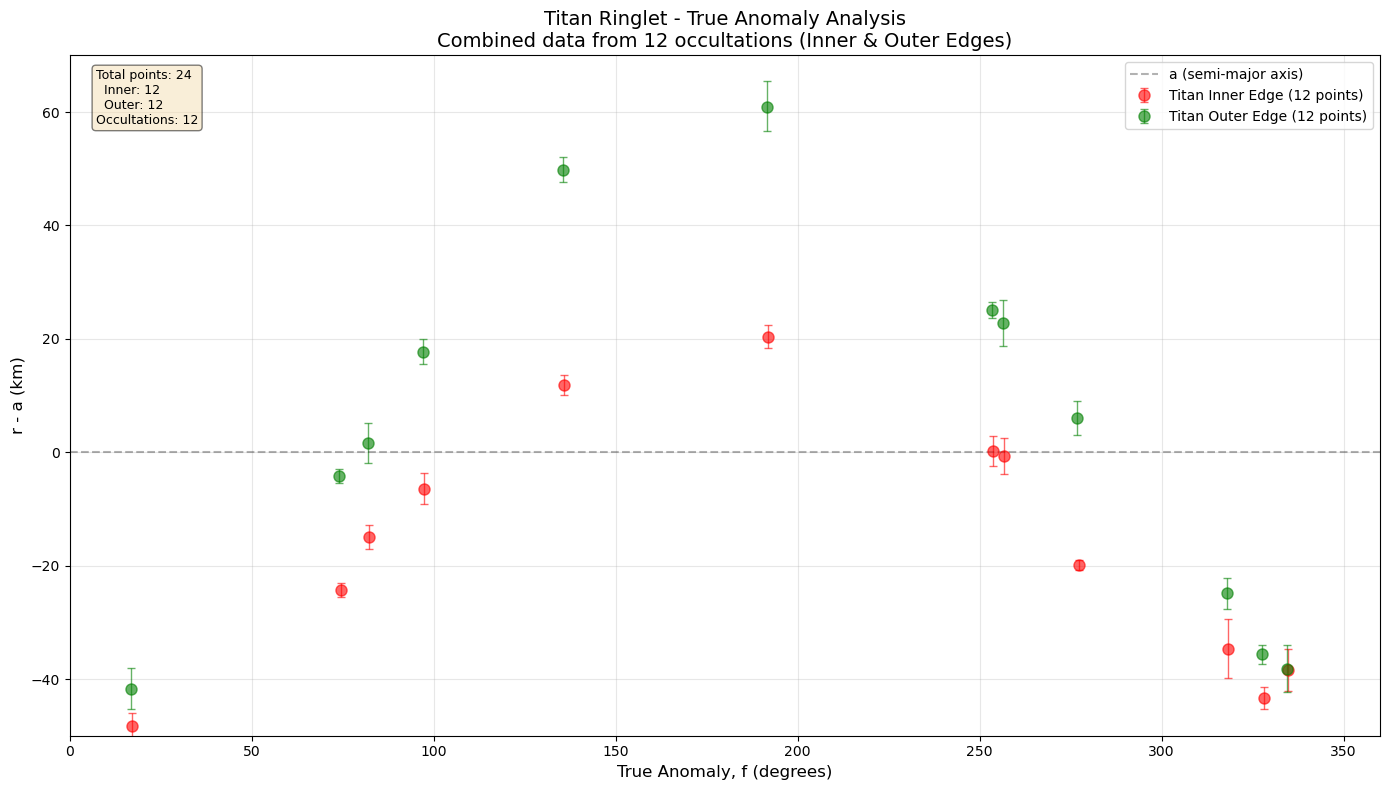


Plot generated with 24 total data points from 12 CSV files
  - Inner edge: 12 points (red circles)
  - Outer edge: 12 points (green squares)


In [9]:
# This section plots the model curve with ALL data points from all occultations for Titan ringlet

plt.figure(figsize=(14, 8))

# Plot inner edge data points with error bars (red circles)
plt.errorbar(all_true_anomaly_inner, all_radii_inner - a_paper, 
             yerr=[all_TAUMINUS_inner, all_TAUPLUS_inner],  # Asymmetric error bars
             fmt='ro', markersize=8, capsize=3, capthick=1, 
             label=f'Titan Inner Edge ({len(all_true_anomaly_inner)} points)', 
             alpha=0.6, elinewidth=1)

# Plot outer edge data points with error bars (green circles)
plt.errorbar(all_true_anomaly_outer, all_radii_outer - a_paper, 
             yerr=[all_TAUMINUS_outer, all_TAUPLUS_outer],  # Asymmetric error bars
             fmt='go', markersize=8, capsize=3, capthick=1,
             label=f'Titan Outer Edge ({len(all_true_anomaly_outer)} points)', 
             alpha=0.6, elinewidth=1)

# Formatting
plt.xlabel('True Anomaly, f (degrees)', fontsize=12)
plt.ylabel('r - a (km)', fontsize=12)
plt.title(f'Titan Ringlet - True Anomaly Analysis\nCombined data from {len(all_csv_names)} occultations (Inner & Outer Edges)', fontsize=14)
plt.xlim(0, 360)
plt.ylim(-50, 70)
plt.axhline(y=0, color='k', linestyle='--', alpha=0.3, label='a (semi-major axis)')
plt.legend(fontsize=10, loc='best')
plt.grid(True, alpha=0.3)

# Add text box with statistics
total_points = len(all_true_anomaly_inner) + len(all_true_anomaly_outer)
stats_text = f'Total points: {total_points}\n'
stats_text += f'  Inner: {len(all_true_anomaly_inner)}\n'
stats_text += f'  Outer: {len(all_true_anomaly_outer)}\n'
stats_text += f'Occultations: {len(all_csv_names)}'

plt.text(0.02, 0.98, stats_text, transform=plt.gca().transAxes, 
         fontsize=9, verticalalignment='top', 
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()

print(f"\nPlot generated with {total_points} total data points from {len(all_csv_names)} CSV files")
print(f"  - Inner edge: {len(all_true_anomaly_inner)} points (red circles)")
print(f"  - Outer edge: {len(all_true_anomaly_outer)} points (green squares)")

In [10]:
# ========== MAXWELL RINGLET ANALYSIS ==========

# This section defines static parameters and initializes data storage for Maxwell Ringlet
#a_paper = 87509.825  # km
#aeI = 18.93    # ae Inner
#aeO = 58.02    # ae Outer
#varpi_0I = 55.60  # degrees Inner
#varpi_0O = 57.20  # degrees Outer
#varpi_dotI = 14.69572  # ϖ̇ in degrees/day Inner
#varpi_dotO = 14.69314  # ϖ̇ in degrees/day Outer

# Initialize lists to store data points from all occultations for Maxwell
# Separate lists for inner and outer edges
#maxwell_true_anomaly_inner = []
#maxwell_radii_inner = []
#maxwell_longitudes_inner = []
#maxwell_times_inner = []
#maxwell_TAUPLUS_inner = []
#maxwell_TAUMINUS_inner = []
#maxwell_true_anomaly_outer = []
#maxwell_radii_outer = []
#maxwell_longitudes_outer = []
#maxwell_times_outer = []
#maxwell_TAUPLUS_outer = []
#maxwell_TAUMINUS_outer = []
#maxwell_csv_names = []

#print("\n" + "="*60)
#print("MAXWELL RINGLET - Initializing data storage")
#print("="*60)

In [11]:
"""
# This section loops through all CSV files and processes each one for Maxwell Ringlet
print(f"\nProcessing {len(csv_files)} CSV files for Maxwell...\n")

for csv_file in csv_files:
    csv_name = os.path.basename(csv_file)
    print(f"Processing: {csv_name}")
    
    try:
        # Load data from CSV
        data = pd.read_csv(csv_file)
        
        # Get Maxwell inner and outer edge data
        maxwell_inner = data[data['Ringlet_Position'] == 'Maxwell_Inner']
        maxwell_outer = data[data['Ringlet_Position'] == 'Maxwell_Outer']
        
        if len(maxwell_inner) == 0 and len(maxwell_outer) == 0:
            print(f"  ⚠ No Maxwell ringlet data found in {csv_name}")
            continue
        
        # Process Inner Edge
        if len(maxwell_inner) > 0:
            # Extract radius value from CSV for inner edge
            a_inner = maxwell_inner['Radius'].values[0]
            
            # Calculate eccentricity (using ae from paper then using our radial value)
            e_inner = aeI / a_inner
            
            # Get longitude from data
            longitude_inner = maxwell_inner['LON'].values[0]  # LON in degrees

            # Get TAUPLUS from data
            TAUPLUS_inner = maxwell_inner['TAUPLUS'].values[0]  # TAUPLUS

            # Get TAUMINUS from data
            TAUMINUS_inner = maxwell_inner['TAUMINUS'].values[0]  # TAUMINUS
            
            # Convert ET time from seconds to days
            maxwell_et_days_inner = maxwell_inner['ET'].values[0] / 86400.0
            
            # Convert to Julian Days
            maxwell_jd_et_inner = j2000_jd + maxwell_et_days_inner
            
            # Calculate true anomaly (comes out in degrees after wrapping)
            true_anomaly_inner = calculate_true_anomaly(longitude_inner, varpi_0I, varpi_dotI, 
                                                 maxwell_jd_et_inner, paper_epoch_jd_et)
            
            # Convert to radians before calculating radius
            true_anomaly_rad_inner = true_anomaly_inner * np.pi / 180
            
            # Calculate radii
            radii_inner = calculate_radius_true_anomaly(a_inner, e_inner, true_anomaly_rad_inner)
            
            # Store inner edge data points
            maxwell_true_anomaly_inner.append(true_anomaly_inner)
            maxwell_radii_inner.append(radii_inner)
            maxwell_longitudes_inner.append(longitude_inner)
            maxwell_times_inner.append(maxwell_jd_et_inner)
            maxwell_TAUPLUS_inner.append(TAUPLUS_inner)
            maxwell_TAUMINUS_inner.append(TAUMINUS_inner)
            
            print(f"  ✓ Inner edge: a = {a_inner:.2f} km")
        
        # Process Outer Edge
        if len(maxwell_outer) > 0:
            # Extract radius value from CSV for outer edge
            a_outer = maxwell_outer['Radius'].values[0]
            
            # Calculate eccentricity (using ae from paper then using our radial value)
            e_outer = aeO / a_outer
            
            # Get longitude from data
            longitude_outer = maxwell_outer['LON'].values[0]  # LON in degrees

            # Get TAUPLUS from data
            TAUPLUS_outer = maxwell_outer['TAUPLUS'].values[0]  # TAUPLUS

            # Get TAUMINUS from data
            TAUMINUS_outer = maxwell_outer['TAUMINUS'].values[0]  # TAUMINUS
            
            # Convert ET time from seconds to days
            maxwell_et_days_outer = maxwell_outer['ET'].values[0] / 86400.0
            
            # Convert to Julian Days
            maxwell_jd_et_outer = j2000_jd + maxwell_et_days_outer
            
            # Calculate true anomaly (comes out in degrees after wrapping)
            true_anomaly_outer = calculate_true_anomaly(longitude_outer, varpi_0O, varpi_dotO, 
                                                 maxwell_jd_et_outer, paper_epoch_jd_et)
            
            # Convert to radians before calculating radius
            true_anomaly_rad_outer = true_anomaly_outer * np.pi / 180
            
            # Calculate radii
            radii_outer = calculate_radius_true_anomaly(a_outer, e_outer, true_anomaly_rad_outer)
            
            # Store outer edge data points
            maxwell_true_anomaly_outer.append(true_anomaly_outer)
            maxwell_radii_outer.append(radii_outer)
            maxwell_longitudes_outer.append(longitude_outer)
            maxwell_times_outer.append(maxwell_jd_et_outer)
            maxwell_TAUPLUS_outer.append(TAUPLUS_outer)
            maxwell_TAUMINUS_outer.append(TAUMINUS_outer)
            
            print(f"  ✓ Outer edge: a = {a_outer:.2f} km")
        
        maxwell_csv_names.append(csv_name)
        
    except Exception as ex:
        print(f"  ✗ Error processing {csv_name}: {ex}")
        import traceback
        traceback.print_exc()
        continue

# Convert lists to numpy arrays
maxwell_true_anomaly_inner = np.array(maxwell_true_anomaly_inner)
maxwell_radii_inner = np.array(maxwell_radii_inner)
maxwell_longitudes_inner = np.array(maxwell_longitudes_inner)
maxwell_times_inner = np.array(maxwell_times_inner)
maxwell_TAUPLUS_inner = np.array(maxwell_TAUPLUS_inner)
maxwell_TAUMINUS_inner = np.array(maxwell_TAUMINUS_inner)

maxwell_true_anomaly_outer = np.array(maxwell_true_anomaly_outer)
maxwell_radii_outer = np.array(maxwell_radii_outer)
maxwell_longitudes_outer = np.array(maxwell_longitudes_outer)
maxwell_times_outer = np.array(maxwell_times_outer)
maxwell_TAUPLUS_outer = np.array(maxwell_TAUPLUS_outer)
maxwell_TAUMINUS_outer = np.array(maxwell_TAUMINUS_outer)

print(f"\n{'='*60}")
print(f"MAXWELL RINGLET - TOTAL DATA POINTS COLLECTED:")
print(f"  Inner edge: {len(maxwell_true_anomaly_inner)} points")
print(f"  Outer edge: {len(maxwell_true_anomaly_outer)} points")
print(f"  Total: {len(maxwell_true_anomaly_inner) + len(maxwell_true_anomaly_outer)} points")
print(f"  Total Tau+- values Inner: {len(maxwell_TAUPLUS_inner) + len(maxwell_TAUMINUS_inner)} points")
print(f"  Total Tau+- values Outer: {len(maxwell_TAUPLUS_outer) + len(maxwell_TAUMINUS_outer)} points")
print(f"{'='*60}")

if len(maxwell_true_anomaly_inner) > 0:
    print(f"Inner - True anomaly: {np.min(maxwell_true_anomaly_inner):.2f}° to {np.max(maxwell_true_anomaly_inner):.2f}°")
    print(f"Inner - Radii: {np.min(maxwell_radii_inner):.2f} to {np.max(maxwell_radii_inner):.2f} km")

if len(maxwell_true_anomaly_outer) > 0:
    print(f"Outer - True anomaly: {np.min(maxwell_true_anomaly_outer):.2f}° to {np.max(maxwell_true_anomaly_outer):.2f}°")
    print(f"Outer - Radii: {np.min(maxwell_radii_outer):.2f} to {np.max(maxwell_radii_outer):.2f} km")
"""

'\n# This section loops through all CSV files and processes each one for Maxwell Ringlet\nprint(f"\nProcessing {len(csv_files)} CSV files for Maxwell...\n")\n\nfor csv_file in csv_files:\n    csv_name = os.path.basename(csv_file)\n    print(f"Processing: {csv_name}")\n    \n    try:\n        # Load data from CSV\n        data = pd.read_csv(csv_file)\n        \n        # Get Maxwell inner and outer edge data\n        maxwell_inner = data[data[\'Ringlet_Position\'] == \'Maxwell_Inner\']\n        maxwell_outer = data[data[\'Ringlet_Position\'] == \'Maxwell_Outer\']\n        \n        if len(maxwell_inner) == 0 and len(maxwell_outer) == 0:\n            print(f"  ⚠ No Maxwell ringlet data found in {csv_name}")\n            continue\n        \n        # Process Inner Edge\n        if len(maxwell_inner) > 0:\n            # Extract radius value from CSV for inner edge\n            a_inner = maxwell_inner[\'Radius\'].values[0]\n            \n            # Calculate eccentricity (using ae from p

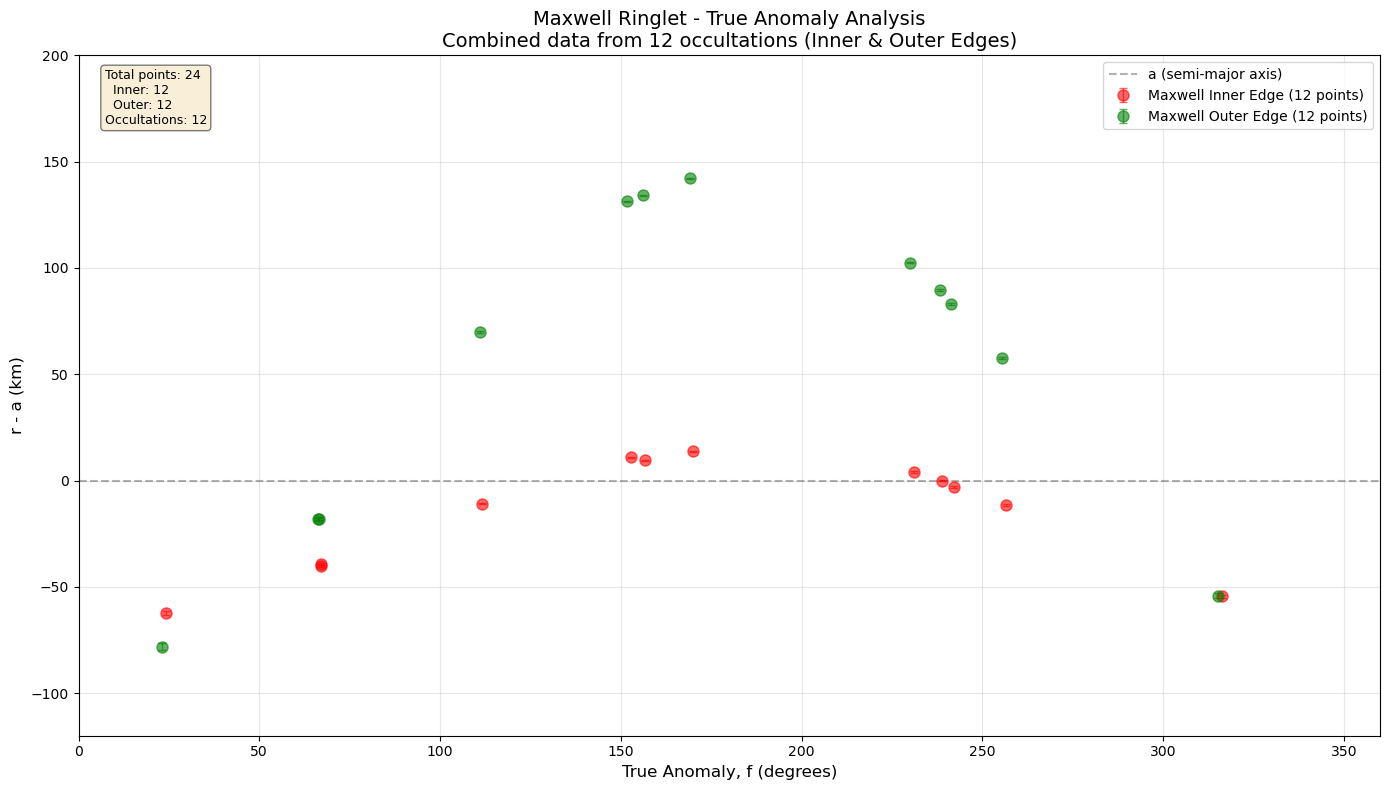


Plot generated with 24 total data points from 12 CSV files
  - Inner edge: 12 points (red circles)
  - Outer edge: 12 points (green circles)


In [64]:
# This section plots the model curve with ALL data points from all occultations for Maxwell ringlet

plt.figure(figsize=(14, 8))

# Plot inner edge data points with error bars (red circles)
plt.errorbar(maxwell_true_anomaly_inner, maxwell_radii_inner - a_paper, 
             yerr=[maxwell_TAUMINUS_inner, maxwell_TAUPLUS_inner],  # Asymmetric error bars
             fmt='ro', markersize=8, capsize=3, capthick=1, 
             label=f'Maxwell Inner Edge ({len(maxwell_true_anomaly_inner)} points)', 
             alpha=0.6, elinewidth=1)

# Plot outer edge data points with error bars (green circles)
plt.errorbar(maxwell_true_anomaly_outer, maxwell_radii_outer - a_paper, 
             yerr=[maxwell_TAUMINUS_outer, maxwell_TAUPLUS_outer],  # Asymmetric error bars
             fmt='go', markersize=8, capsize=3, capthick=1,
             label=f'Maxwell Outer Edge ({len(maxwell_true_anomaly_outer)} points)', 
             alpha=0.6, elinewidth=1)

# Formatting
plt.xlabel('True Anomaly, f (degrees)', fontsize=12)
plt.ylabel('r - a (km)', fontsize=12)
plt.title(f'Maxwell Ringlet - True Anomaly Analysis\nCombined data from {len(maxwell_csv_names)} occultations (Inner & Outer Edges)', fontsize=14)
plt.xlim(0, 360)
plt.ylim(-120, 200)
plt.axhline(y=0, color='k', linestyle='--', alpha=0.3, label='a (semi-major axis)')
plt.legend(fontsize=10, loc='best')
plt.grid(True, alpha=0.3)

# Add text box with statistics
maxwell_total_points = len(maxwell_true_anomaly_inner) + len(maxwell_true_anomaly_outer)
stats_text = f'Total points: {maxwell_total_points}\n'
stats_text += f'  Inner: {len(maxwell_true_anomaly_inner)}\n'
stats_text += f'  Outer: {len(maxwell_true_anomaly_outer)}\n'
stats_text += f'Occultations: {len(maxwell_csv_names)}'

plt.text(0.02, 0.98, stats_text, transform=plt.gca().transAxes, 
         fontsize=9, verticalalignment='top', 
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()

print(f"\nPlot generated with {maxwell_total_points} total data points from {len(maxwell_csv_names)} CSV files")
print(f"  - Inner edge: {len(maxwell_true_anomaly_inner)} points (red circles)")
print(f"  - Outer edge: {len(maxwell_true_anomaly_outer)} points (green circles)")

/var/folders/wq/cx49pysn7p1gpkypp6fcfsbm0000gn/T/ipykernel_32958/477433299.py:50: RuntimeWarning: invalid value encountered in arccos
  true_anomaly_from_radius = np.arccos(cos_f) * 180 / np.pi


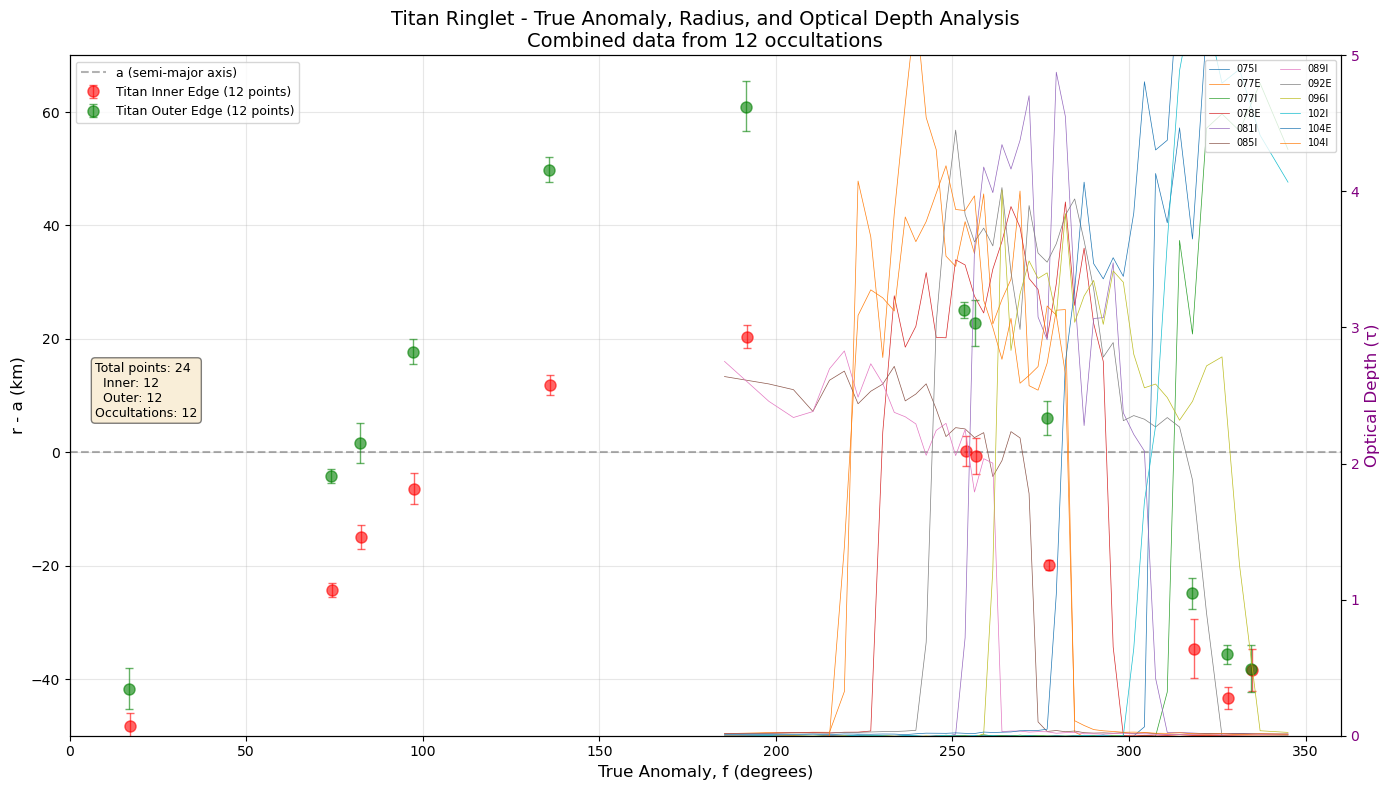


Plot generated with 24 total data points from 12 CSV files
  - Inner edge: 12 points (red circles)
  - Outer edge: 12 points (green circles)
  - Optical depth profiles from 12 occultations


In [12]:
# Create the plot with twin axes
fig, ax1 = plt.subplots(figsize=(14, 8))

# Plot inner edge data points with error bars (red circles)
ax1.errorbar(all_true_anomaly_inner, all_radii_inner - a_paper, 
             yerr=[all_TAUMINUS_inner, all_TAUPLUS_inner],
             fmt='ro', markersize=8, capsize=3, capthick=1, 
             label=f'Titan Inner Edge ({len(all_true_anomaly_inner)} points)', 
             alpha=0.6, elinewidth=1, zorder=5)

# Plot outer edge data points with error bars (green circles)
ax1.errorbar(all_true_anomaly_outer, all_radii_outer - a_paper, 
             yerr=[all_TAUMINUS_outer, all_TAUPLUS_outer],
             fmt='go', markersize=8, capsize=3, capthick=1,
             label=f'Titan Outer Edge ({len(all_true_anomaly_outer)} points)', 
             alpha=0.6, elinewidth=1, zorder=5)

# Format primary y-axis
ax1.set_xlabel('True Anomaly, f (degrees)', fontsize=12)
ax1.set_ylabel('r - a (km)', fontsize=12, color='black')
ax1.set_xlim(0, 360)
ax1.set_ylim(-50, 70)
ax1.axhline(y=0, color='k', linestyle='--', alpha=0.3, label='a (semi-major axis)')
ax1.tick_params(axis='y', labelcolor='black')
ax1.grid(True, alpha=0.3)

# SECONDARY AXIS (RIGHT Y-AXIS): Optical Depth (τ)
ax2 = ax1.twinx()

# Now we need to plot tau vs true anomaly
# For each occultation, we need to convert radius to true anomaly
for occ_id, data in all_occultation_data.items():
    radius = data['radius']
    tau = data['tau']
    
    # Convert radius to true anomaly using inverse of orbital equation
    # r = a(1-e²)/(1+e·cos(f))
    # Solving for f: cos(f) = (a(1-e²)/r - 1)/e
    
    # Filter for Titan ringlet region only (around 77883 km)
    titan_mask = (radius >= 77500) & (radius <= 78500)
    radius_titan = radius[titan_mask]
    tau_titan = tau[titan_mask]
    
    # Calculate true anomaly from radius
    numerator_inv = a_paper * (1 - e_paper**2)
    cos_f = (numerator_inv / radius_titan - 1) / e_paper
    
    # Calculate true anomaly in radians then convert to degrees
    true_anomaly_from_radius = np.arccos(cos_f) * 180 / np.pi
    
    # Determine which half of the orbit we're on
    # The radius decreases from apoapsis to periapsis (0° to 180°)
    # and increases from periapsis to apoapsis (180° to 360°)
    radius_gradient = np.gradient(radius_titan)
    
    # If radius is increasing, we're on the second half (180° to 360°)
    # Use: f = 360° - arccos(...)
    true_anomaly_from_radius = np.where(radius_gradient > 0, 
                                         360 - true_anomaly_from_radius, 
                                         true_anomaly_from_radius)
    
    # Plot optical depth vs true anomaly
    ax2.plot(true_anomaly_from_radius, tau_titan, '-', linewidth=0.5, 
             alpha=1, label=f'{occ_id}')

# Format secondary y-axis
ax2.set_ylabel('Optical Depth (τ)', fontsize=12, color='purple')
ax2.tick_params(axis='y', labelcolor='purple')
ax2.set_ylim(0, 5)  # Adjust based on your tau range

# Title
plt.title(f'Titan Ringlet - True Anomaly, Radius, and Optical Depth Analysis\nCombined data from {len(all_csv_names)} occultations', 
          fontsize=14)

# Legends
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1, labels1, fontsize=9, loc='upper left')
ax2.legend(lines2, labels2, fontsize=7, loc='upper right', ncol=2)

# Add text box with statistics
total_points = len(all_true_anomaly_inner) + len(all_true_anomaly_outer)
stats_text = f'Total points: {total_points}\n'
stats_text += f'  Inner: {len(all_true_anomaly_inner)}\n'
stats_text += f'  Outer: {len(all_true_anomaly_outer)}\n'
stats_text += f'Occultations: {len(all_csv_names)}'

ax1.text(0.02, 0.55, stats_text, transform=ax1.transAxes, 
         fontsize=9, verticalalignment='top', 
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()

print(f"\nPlot generated with {total_points} total data points from {len(all_csv_names)} CSV files")
print(f"  - Inner edge: {len(all_true_anomaly_inner)} points (red circles)")
print(f"  - Outer edge: {len(all_true_anomaly_outer)} points (green circles)")
print(f"  - Optical depth profiles from {len(all_occultation_data)} occultations")

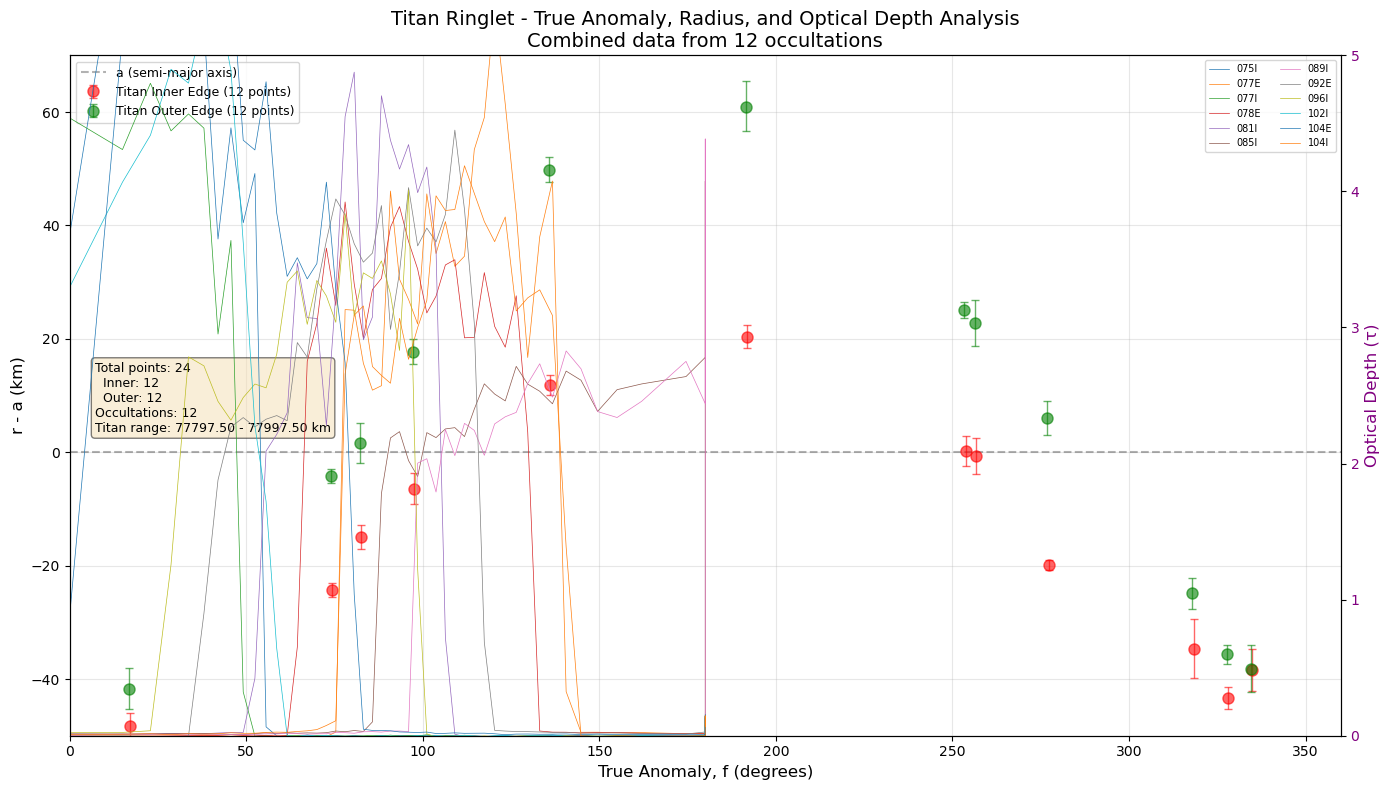


Plot generated with 24 total data points from 12 CSV files
  - Inner edge: 12 points (red circles)
  - Outer edge: 12 points (green circles)
  - Optical depth profiles from 12 occultations
  - Titan ringlet range: 77797.50 - 77997.50 km (center: 77897.5 km)


In [13]:
# Create the plot with twin axes
fig, ax1 = plt.subplots(figsize=(14, 8))

# Plot inner edge data points with error bars (red circles)
ax1.errorbar(all_true_anomaly_inner, all_radii_inner - a_paper, 
             yerr=[all_TAUMINUS_inner, all_TAUPLUS_inner],
             fmt='ro', markersize=8, capsize=3, capthick=1, 
             label=f'Titan Inner Edge ({len(all_true_anomaly_inner)} points)', 
             alpha=0.6, elinewidth=1, zorder=5)

# Plot outer edge data points with error bars (green circles)
ax1.errorbar(all_true_anomaly_outer, all_radii_outer - a_paper, 
             yerr=[all_TAUMINUS_outer, all_TAUPLUS_outer],
             fmt='go', markersize=8, capsize=3, capthick=1,
             label=f'Titan Outer Edge ({len(all_true_anomaly_outer)} points)', 
             alpha=0.6, elinewidth=1, zorder=5)

# Format primary y-axis
ax1.set_xlabel('True Anomaly, f (degrees)', fontsize=12)
ax1.set_ylabel('r - a (km)', fontsize=12, color='black')
ax1.set_xlim(0, 360)
ax1.set_ylim(-50, 70)
ax1.axhline(y=0, color='k', linestyle='--', alpha=0.3, label='a (semi-major axis)')
ax1.tick_params(axis='y', labelcolor='black')
ax1.grid(True, alpha=0.3)

# SECONDARY AXIS (RIGHT Y-AXIS): Optical Depth (τ)
ax2 = ax1.twinx()

# Define Titan ringlet center and range
titan_center = 77897.50  # km (refined center from your analysis)
titan_range = 100  # km (±100 km)
titan_min = titan_center - titan_range  # 77797.50 km
titan_max = titan_center + titan_range  # 77997.50 km

# Now we need to plot tau vs true anomaly
# For each occultation, we need to convert radius to true anomaly
for occ_id, data in all_occultation_data.items():
    radius = data['radius']
    tau = data['tau']
    
    # Convert radius to true anomaly using inverse of orbital equation
    # r = a(1-e²)/(1+e·cos(f))
    # Solving for f: cos(f) = (a(1-e²)/r - 1)/e
    
    # Filter for Titan ringlet region only (77797.50 - 77997.50 km)
    titan_mask = (radius >= titan_min) & (radius <= titan_max)
    radius_titan = radius[titan_mask]
    tau_titan = tau[titan_mask]
    
    # Calculate true anomaly from radius
    numerator_inv = a_paper * (1 - e_paper**2)
    cos_f = (numerator_inv / radius_titan - 1) / e_paper
    
    # Clip values to [-1, 1] to avoid arccos errors
    cos_f = np.clip(cos_f, -1, 1)
    
    # Calculate true anomaly in radians then convert to degrees
    # arccos gives 0 to 180, we need to determine if we're on ascending or descending part
    true_anomaly_0_180 = np.arccos(cos_f) * 180 / np.pi
    
    # To get 0-360 range, we need to check if radius is increasing or decreasing
    # Calculate the derivative (difference) of radius
    radius_diff = np.diff(radius_titan)
    
    # Pad the diff array to match the original length
    radius_diff = np.append(radius_diff, radius_diff[-1])
    
    # If radius is increasing, we're going from periapse (0°) to apoapse (180°)
    # If radius is decreasing, we're going from apoapse (180°) to periapse (360°)
    true_anomaly_from_radius = np.where(radius_diff > 0, 
                                        true_anomaly_0_180,  # 0-180°
                                        360 - true_anomaly_0_180)  # 180-360°
    
    # Plot optical depth vs true anomaly
    ax2.plot(true_anomaly_from_radius, tau_titan, '-', linewidth=0.5, 
             alpha=1, label=f'{occ_id}')

# Format secondary y-axis
ax2.set_ylabel('Optical Depth (τ)', fontsize=12, color='purple')
ax2.tick_params(axis='y', labelcolor='purple')
ax2.set_ylim(0, 5)  # Adjust based on your tau range

# Title
plt.title(f'Titan Ringlet - True Anomaly, Radius, and Optical Depth Analysis\nCombined data from {len(all_csv_names)} occultations', 
          fontsize=14)

# Legends
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1, labels1, fontsize=9, loc='upper left')
ax2.legend(lines2, labels2, fontsize=7, loc='upper right', ncol=2)

# Add text box with statistics
total_points = len(all_true_anomaly_inner) + len(all_true_anomaly_outer)
stats_text = f'Total points: {total_points}\n'
stats_text += f'  Inner: {len(all_true_anomaly_inner)}\n'
stats_text += f'  Outer: {len(all_true_anomaly_outer)}\n'
stats_text += f'Occultations: {len(all_csv_names)}\n'
stats_text += f'Titan range: {titan_min:.2f} - {titan_max:.2f} km'

ax1.text(0.02, 0.55, stats_text, transform=ax1.transAxes, 
         fontsize=9, verticalalignment='top', 
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()

print(f"\nPlot generated with {total_points} total data points from {len(all_csv_names)} CSV files")
print(f"  - Inner edge: {len(all_true_anomaly_inner)} points (red circles)")
print(f"  - Outer edge: {len(all_true_anomaly_outer)} points (green circles)")
print(f"  - Optical depth profiles from {len(all_occultation_data)} occultations")
print(f"  - Titan ringlet range: {titan_min:.2f} - {titan_max:.2f} km (center: {titan_center} km)")

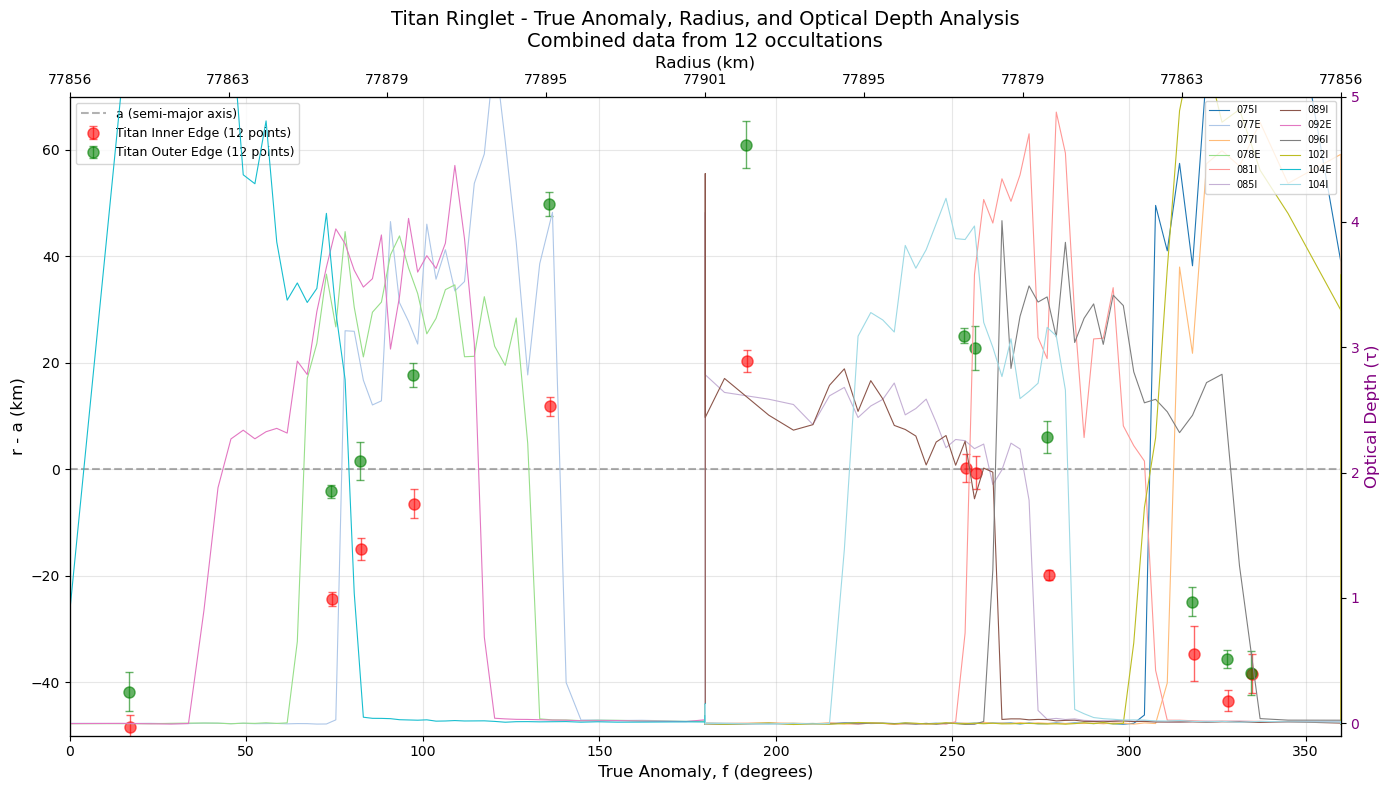

In [28]:
# Create the plot with twin axes
fig, ax1 = plt.subplots(figsize=(14, 8))

# Plot inner edge data points with error bars (red circles)
ax1.errorbar(all_true_anomaly_inner, all_radii_inner - a_paper, 
             yerr=[all_TAUMINUS_inner, all_TAUPLUS_inner],
             fmt='ro', markersize=8, capsize=3, capthick=1, 
             label=f'Titan Inner Edge ({len(all_true_anomaly_inner)} points)', 
             alpha=0.6, elinewidth=1, zorder=5)

# Plot outer edge data points with error bars (green circles)
ax1.errorbar(all_true_anomaly_outer, all_radii_outer - a_paper, 
             yerr=[all_TAUMINUS_outer, all_TAUPLUS_outer],
             fmt='go', markersize=8, capsize=3, capthick=1,
             label=f'Titan Outer Edge ({len(all_true_anomaly_outer)} points)', 
             alpha=0.6, elinewidth=1, zorder=5)

# Format primary y-axis
ax1.set_xlabel('True Anomaly, f (degrees)', fontsize=12)
ax1.set_ylabel('r - a (km)', fontsize=12, color='black')
ax1.set_xlim(0, 360)
ax1.set_ylim(-50, 70)
ax1.axhline(y=0, color='k', linestyle='--', alpha=0.3, label='a (semi-major axis)')
ax1.tick_params(axis='y', labelcolor='black')
ax1.grid(True, alpha=0.3)

# SECONDARY AXIS (RIGHT Y-AXIS): Optical Depth (τ)
ax2 = ax1.twinx()

# SECONDARY AXIS (TOP X-AXIS): Radius
ax3 = ax1.twiny()

# Calculate radius range from true anomaly range (0 to 360 degrees)
# Using orbital equation: r = a(1-e²)/(1+e·cos(f))
true_anomaly_range = np.linspace(0, 360, 1000)  # degrees
true_anomaly_rad = true_anomaly_range * np.pi / 180
radius_range = a_paper * (1 - e_paper**2) / (1 + e_paper * np.cos(true_anomaly_rad))

# Set the radius axis limits and labels
ax3.set_xlim(0, 360)  # Still in true anomaly coordinates
ax3.set_xlabel('Radius (km)', fontsize=12)

# Create custom tick positions and labels
# Pick some representative true anomaly values and calculate their radii
tick_anomalies = np.array([0, 45, 90, 135, 180, 225, 270, 315, 360])
tick_radii = a_paper * (1 - e_paper**2) / (1 + e_paper * np.cos(tick_anomalies * np.pi / 180))

ax3.set_xticks(tick_anomalies)
ax3.set_xticklabels([f'{r:.0f}' for r in tick_radii])

# Path to CSV files with median ringlet data
csv_directory = '/Volumes/Flash Drive/Saturns rings Research/Data From Center of Ringlets CSV files/Center Median Ringlets'

# Range around the center (±100 km)
titan_range = 100  # km

# For more colors to see the graph
n_occultations = len(all_occultation_data)
colors = cm.tab20(np.linspace(0, 1, n_occultations))

# Now we need to plot tau vs true anomaly
# For each occultation, we need to convert radius to true anomaly
for idx, (occ_id, data) in enumerate(all_occultation_data.items()):
    radius = data['radius']
    tau = data['tau']
    
    # Construct the CSV filename for this occultation
    csv_filename = f'BetCen_{occ_id}_1km_ringlet_medians.csv'
    csv_filepath = os.path.join(csv_directory, csv_filename)
    
    # Try to read the CSV file to get the Titan ringlet radius
    try:
        df = pd.read_csv(csv_filepath)
        # Get the Titan ringlet radius from the CSV
        titan_row = df[df['Ringlet'] == 'Titan']
        
        if not titan_row.empty:
            titan_center = titan_row['Radius'].values[0]
            titan_min = titan_center - titan_range
            titan_max = titan_center + titan_range

            #uncomment if you want to see the radius
            #print(f"{occ_id}: Titan center = {titan_center:.2f} km, range = [{titan_min:.2f}, {titan_max:.2f}]")
        else:
            print(f"{occ_id}: Titan ringlet not found in CSV, using default range")
    
    except Exception as EE:
        print(f"{occ_id}: Error reading CSV ({EE})")
    
    # Determine if this is Ingress or Egress from the filename
    # Extract the I or E from the filename (e.g., "BetCen_064E_1km.sav")
    if 'I' in occ_id:
        is_ingress = True
    elif 'E' in occ_id:
        is_ingress = False
    else:
        # If we can't determine, skip or use a default
        print(f"Warning: Could not determine I/E for {occ_id}, skipping...")
        continue
    
    # Filter for Titan ringlet region only
    titan_mask = (radius >= titan_min) & (radius <= titan_max)
    radius_titan = radius[titan_mask]
    tau_titan = tau[titan_mask]

    if len(radius_titan) == 0:
        print(f"  No data points in Titan range, skipping")
        continue
    
    # Calculate true anomaly from radius
    numerator_inv = a_paper * (1 - e_paper**2)
    cos_f = (numerator_inv / radius_titan - 1) / e_paper
    
    # Clip values to [-1, 1] to avoid arccos errors
    cos_f = np.clip(cos_f, -1, 1)
    
    # Calculate true anomaly - arccos gives 0 to 180
    true_anomaly_0_180 = np.arccos(cos_f) * 180 / np.pi
    
    # Choose the correct branch based on Ingress/Egress
    if is_ingress:
        # Ingress: use 180-360° range
        true_anomaly_from_radius = 360 - true_anomaly_0_180
    else:
        # Egress: use 0-180° range
        true_anomaly_from_radius = true_anomaly_0_180
    
    # Plot optical depth vs true anomaly
    ax2.plot(true_anomaly_from_radius, tau_titan, '-', linewidth=0.8, 
             alpha=1, color=colors[idx], label=f'{occ_id}')


# Format secondary y-axis
ax2.set_ylabel('Optical Depth (τ)', fontsize=12, color='purple')
ax2.tick_params(axis='y', labelcolor='purple')
ax2.set_ylim(-.1, 5)  # Adjust based on your tau range

# Title
plt.title(f'Titan Ringlet - True Anomaly, Radius, and Optical Depth Analysis\nCombined data from {len(all_csv_names)} occultations', 
          fontsize=14)

# Legends
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1, labels1, fontsize=9, loc='upper left')
ax2.legend(lines2, labels2, fontsize=7, loc='upper right', ncol=2)

plt.tight_layout()
plt.show()

In [25]:
print("\n" + "="*80)
print("Checking data near 180 degrees true anomaly:")
print("="*80)

for occ_id, data in all_occultation_data.items():
    radius = data['radius']
    tau = data['tau']
    
    # Get the Titan ringlet radius from CSV
    csv_filename = f'BetCen_{occ_id}_1km_ringlet_medians.csv'
    csv_filepath = os.path.join(csv_directory, csv_filename)
    
    try:
        df = pd.read_csv(csv_filepath)
        titan_row = df[df['Ringlet'] == 'Titan']
        
        if not titan_row.empty:
            titan_center = titan_row['Radius'].values[0]
            titan_min = titan_center - titan_range
            titan_max = titan_center + titan_range
        else:
            continue
    except:
        continue
    
    # Filter for Titan ringlet region
    titan_mask = (radius >= titan_min) & (radius <= titan_max)
    radius_titan = radius[titan_mask]
    tau_titan = tau[titan_mask]
    
    if len(radius_titan) == 0:
        continue
    
    # Calculate true anomaly
    numerator_inv = a_paper * (1 - e_paper**2)
    cos_f = (numerator_inv / radius_titan - 1) / e_paper
    cos_f = np.clip(cos_f, -1, 1)
    true_anomaly_0_180 = np.arccos(cos_f) * 180 / np.pi
    
    # Apply ingress/egress logic
    if 'I' in occ_id:
        true_anomaly_from_radius = 360 - true_anomaly_0_180
    else:
        true_anomaly_from_radius = true_anomaly_0_180
    
    # Find points near 180 degrees (within ±10 degrees)
    near_180_mask = np.abs(true_anomaly_from_radius - 180) < 10
    
    if np.any(near_180_mask):
        angles_near_180 = true_anomaly_from_radius[near_180_mask]
        tau_near_180 = tau_titan[near_180_mask]
        radius_near_180 = radius_titan[near_180_mask]
        
        print(f"\n{occ_id}:")
        print(f"  Points near 180°: {np.sum(near_180_mask)}")
        print(f"  True anomaly range: [{angles_near_180.min():.2f}, {angles_near_180.max():.2f}]")
        print(f"  Tau range: [{tau_near_180.min():.4f}, {tau_near_180.max():.4f}]")
        print(f"  Max tau value: {tau_near_180.max():.4f} at f = {angles_near_180[np.argmax(tau_near_180)]:.2f}°")
        print(f"  Radius range: [{radius_near_180.min():.2f}, {radius_near_180.max():.2f}] km")
        
        # Check for anomalous spikes
        if tau_near_180.max() > 2.0:  # Adjust threshold as needed
            print(f"  *** POTENTIAL SPIKE DETECTED ***<-----------------------------------")


Checking data near 180 degrees true anomaly:

075I:
  Points near 180°: 60
  True anomaly range: [180.00, 185.45]
  Tau range: [-0.0053, 0.1299]
  Max tau value: 0.1299 at f = 180.00°
  Radius range: [77901.00, 77960.00] km

077E:
  Points near 180°: 84
  True anomaly range: [174.55, 180.00]
  Tau range: [-0.0035, 0.1417]
  Max tau value: 0.1417 at f = 180.00°
  Radius range: [77901.00, 77984.00] km

077I:
  Points near 180°: 55
  True anomaly range: [180.00, 185.45]
  Tau range: [-0.0074, 0.1406]
  Max tau value: 0.1406 at f = 180.00°
  Radius range: [77901.00, 77955.00] km

078E:
  Points near 180°: 81
  True anomaly range: [174.55, 180.00]
  Tau range: [0.0022, 0.1436]
  Max tau value: 0.1436 at f = 180.00°
  Radius range: [77901.00, 77981.00] km

081I:
  Points near 180°: 75
  True anomaly range: [180.00, 185.45]
  Tau range: [-0.0068, 0.1279]
  Max tau value: 0.1279 at f = 180.00°
  Radius range: [77901.00, 77975.00] km

085I:
  Points near 180°: 93
  True anomaly range: [180.00,

In [27]:
print("\nDetailed investigation of spikes:")

for spike_occ in ['085I', '089I']:
    if spike_occ in all_occultation_data:
        data = all_occultation_data[spike_occ]
        radius = data['radius']
        tau = data['tau']
        
        # Get Titan range
        csv_filename = f'BetCen_{spike_occ}_1km_ringlet_medians.csv'
        csv_filepath = os.path.join(csv_directory, csv_filename)
        df = pd.read_csv(csv_filepath)
        titan_row = df[df['Ringlet'] == 'Titan']
        titan_center = titan_row['Radius'].values[0]
        titan_min = titan_center - titan_range
        titan_max = titan_center + titan_range
        
        # Filter
        titan_mask = (radius >= titan_min) & (radius <= titan_max)
        radius_titan = radius[titan_mask]
        tau_titan = tau[titan_mask]
        
        # Find the exact spike location
        spike_idx = np.argmax(tau_titan)
        print(f"\n{spike_occ}:")
        print(f"  Spike at index: {spike_idx}/{len(tau_titan)}")
        print(f"  Radius: {radius_titan[spike_idx]:.2f} km")
        print(f"  Tau: {tau_titan[spike_idx]:.4f}")
        print(f"  Surrounding tau values (±30 points):")
        start = max(0, spike_idx - 30)
        end = min(len(tau_titan), spike_idx + 31)
        for i in range(start, end):
            marker = " <--SPIKE" if i == spike_idx else ""
            print(f"    [{i}] r={radius_titan[i]:.2f} km, tau={tau_titan[i]:.4f}{marker}")


Detailed investigation of spikes:

085I:
  Spike at index: 114/200
  Radius: 77908.00 km
  Tau: 4.0750
  Surrounding tau values (±30 points):
    [84] r=77878.00 km, tau=1.7791
    [85] r=77879.00 km, tau=2.1884
    [86] r=77880.00 km, tau=2.2347
    [87] r=77881.00 km, tau=2.0215
    [88] r=77882.00 km, tau=1.9043
    [89] r=77883.00 km, tau=2.2274
    [90] r=77884.00 km, tau=2.1908
    [91] r=77885.00 km, tau=2.2545
    [92] r=77886.00 km, tau=2.2639
    [93] r=77887.00 km, tau=2.1984
    [94] r=77888.00 km, tau=2.4003
    [95] r=77889.00 km, tau=2.5860
    [96] r=77890.00 km, tau=2.5109
    [97] r=77891.00 km, tau=2.4605
    [98] r=77892.00 km, tau=2.7144
    [99] r=77893.00 km, tau=2.5839
    [100] r=77894.00 km, tau=2.5314
    [101] r=77895.00 km, tau=2.4393
    [102] r=77896.00 km, tau=2.6796
    [103] r=77897.00 km, tau=2.6124
    [104] r=77898.00 km, tau=2.3834
    [105] r=77899.00 km, tau=2.5430
    [106] r=77900.00 km, tau=2.5852
    [107] r=77901.00 km, tau=2.6394
    [108]